<a href="https://colab.research.google.com/github/samsomsabu/NATURAL-LANGUAGE-PROCESSING/blob/main/machine_translation_seq2seq_lstms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1 style="font-size:300%; background-color:skyblue; color:grey; padding:60px; font-family:Garamond;"><b>MACHINE TRANSLATION Using Seq2Seq Modelling</b></h1></center>

<h1>Import the Required Libraries</h1>

In [ ]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

<h1> Load the Data </h1>

In [ ]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')

        # read all text
        text = file.read()
        file.close()
        return text

In [ ]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [ ]:
data = read_text("../input/bilingual-sentence-pairs/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [ ]:
deu_eng = deu_eng[:50000,:]

<ul>
    <li style="font-size:150%;">The actual data contains over 150,000 sentence-pairs. However, we will use only the first 50,000 sentence pairs to reduce the training time of the model. You can change this number as per your system’s computation power.</li>
</ul>

<h1> Text Cleaning / Preprocessing</h1>

<ul>
    <li style="font-size:150%;">We will get rid of the punctuation marks and then convert all the text to lower case.</li>
</ul>

In [ ]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Im giving up smoking', 'Ich höre mit dem Rauchen auf',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #256952 (minshirui) & #407184 (MUIRIEL)'],
       ['Im glad I was nearby', 'Ich bin froh dass ich in der Nähe war',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2547219 (CK) & #3448316 (Pfirsichbaeumchen)'],
       ['Im glad Tom has gone', 'Ich bin froh dass Tom weg ist',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2547217 (CK) & #5299642 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [ ]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


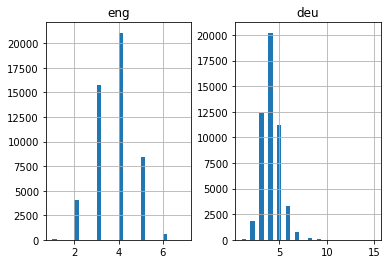

In [ ]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

<ul>
    <li style="font-size:150%;">A Seq2Seq model requires that we convert both the input and the output sentences into integer sequences of fixed length.</li>
    <li style="font-size:150%;">Now, vectorize our text data by using Keras’s Tokenizer() class. It will turn our sentences into sequences of integers. We can then pad those sequences with zeros to make all the sequences of the same length.</li>
    <li style="font-size:150%;">Prepare tokenizers for both the German and English sentences</li>
</ul>

In [ ]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6256


In [ ]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10329


<ul>
    <li style="font-size:150%;">We tokenized the data — i.e., converted the text to numerical values. This allows the neural network to perform operations on the input data.</li>
    <li style="font-size:150%;">When we run the tokenizer, it creates a word index, which is then used to convert each sentence to a vector.</li>

In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

<center><h1 style="font-size:200%; background-color:skyblue; color:black; padding:15px; font-family:Garamond;"><b>Model Building</b></h1></center>

In [ ]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

<ul>
    <li style="font-size:150%;">It’s time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. This has to be done for both the train and test datasets.</li>

In [ ]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

<h1> Define the Model</h1>

In [ ]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [ ]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [ ]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

<ul>
    <li style="font-size:150%;">We are using the RMSprop optimizer in this model as it’s usually a good choice when working with recurrent neural networks.</li>
    <li style="font-size:150%;">Here I have used ‘sparse_categorical_crossentropy‘ as the loss function. This is because the function allows us to use the target sequence as is, instead of the one-hot encoded format. One-hot encoding the target sequences using such a huge vocabulary might consume our system’s entire memory.</li>
               
</ul>

<h1> Fit the Model</h1>

<ul>
    <li style="font-size:150%;">ModelCheckpoint() function to save the model with the lowest validation loss. I personally prefer this method over early stopping.</li>
</ul>

In [ ]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint],
                    verbose=1)

Epoch 1/30
63/63 [==============================] - 154s 2s/step - loss: 4.3593 - val_loss: 2.8360

Epoch 00001: val_loss improved from inf to 2.83604, saving model to model.h1.24_jan_19
Epoch 2/30
63/63 [==============================] - 147s 2s/step - loss: 2.7773 - val_loss: 2.7174

Epoch 00002: val_loss improved from 2.83604 to 2.71737, saving model to model.h1.24_jan_19
Epoch 3/30
63/63 [==============================] - 146s 2s/step - loss: 2.6554 - val_loss: 2.6125

Epoch 00003: val_loss improved from 2.71737 to 2.61250, saving model to model.h1.24_jan_19
Epoch 4/30
63/63 [==============================] - 147s 2s/step - loss: 2.4642 - val_loss: 2.4365

Epoch 00004: val_loss improved from 2.61250 to 2.43653, saving model to model.h1.24_jan_19
Epoch 5/30
63/63 [==============================] - 146s 2s/step - loss: 2.3096 - val_loss: 2.3143

Epoch 00005: val_loss improved from 2.43653 to 2.31433, saving model to model.h1.24_jan_19
Epoch 6/30
63/63 [==============================]

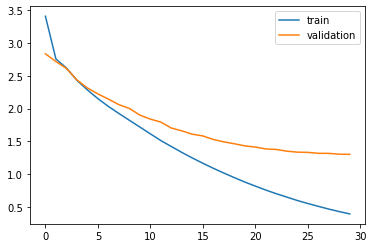

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

<h1> Prediction on unseen data</h1>

In [ ]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [ ]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)

    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [ ]:
# print 15 rows randomly
pred_df.head(15)

actual                predicted
0    i know that already  i already know that    
1               whos she          who is she     
2         do you have it      did you have it    
3          use your feet      get your  stuff    
4   that was the trouble               the       
5   he took off his coat       he put off his    
6   tom went sightseeing   tom staggered the     
7   i tried on the shoes  i answered my shoes    
8       open those doors         the  window     
9    ive got to help tom    i have to help tom   
10          its my money        its my money     
11            is it time          is it time     
12          i cant watch       i cant look in    
13         he wants more   he wants to change    
14       who did you see     who did you seen

<center><h1> CONCLUSION</h1></center>
<br>

<ul>
    <li style="font-size:150%;">Our Seq2Seq model does a decent job. But there are several instances where it misses out on understanding the key words.</li>
    <li style="font-size:150%;">These are the challenges you will face on a regular basis in NLP. But these aren’t immovable obstacles. We can mitigate such challenges by using more training data and building a better (or more complex) model.</li>
</ul>